In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.lstm_ae import *
import torch
import random
from config import *

import numpy as np

In [2]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

In [3]:
folder_list = os.listdir(model_results+ 'lstm_ae/')
print(folder_list)

['pr_2', 'pr_6k', 'pr_1', 'pr_20k', 'pr_2_grace', 'pr_13k', 'first_checkpoint', 'pr_12k', 'lstm_ae_sl_7_emb_8_layers_2_1_sc.pth']


In [4]:
added_path = folder_list[-6]
print(added_path)

In [5]:
model_list = os.listdir(model_results+ 'lstm_ae/{}'.format(added_path))
print(model_list)

['pr_2', 'pr_6k', 'pr_1', 'pr_20k', 'pr_2_grace', 'pr_13k', 'first_checkpoint', 'pr_12k', 'lstm_ae_sl_7_emb_8_layers_2_1_sc.pth']


columns
# 
tempetarue
voltage

logico per ogni routa (segno corrente)

singola routa:
    motocurrent
    speed 
    voltage
    temperature
    
quattro route:
    motocurrent
    speed 
    voltage
    temperature

In [6]:
model_num = -1

#ae_16_ft_4s_sc
print(model_list[model_num])
model_name = model_list[model_num].split('.')[0]

lstm_ae_sl_7_emb_8_layers_2_1_sc.pth


In [7]:
model_results+ 'lstm_ae/{}'.format(added_path) + '/' + model_list[model_num]

'/davinci-1/home/morellir/artificial_intelligence/repos/time_series_anomaly_detection/model_results/lstm_ae//lstm_ae_sl_7_emb_8_layers_2_1_sc.pth'

In [9]:
checkpoint  = torch.load(model_results+ 'lstm_ae/{}'.format(added_path) + '/' + model_list[model_num])
params_conf = checkpoint['param_conf']
cfg = checkpoint['cfg']

In [13]:
cols = params_conf['columns']
cols = cfg.dataset.columns[:cols]
sequence_length = params_conf['sequence_length']
batch_size = params_conf['batch_size']
predict = params_conf['predict']
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
out_window = params_conf['out_window']

n_features = params_conf['n_features']
scaled = params_conf['scaled']
sampling_rate = params_conf['sampling_rate']
shuffle = False

In [15]:
latent_dim = params_conf['latent_dim']
par_nums = checkpoint['parameters_number']
seq_len = params_conf['sequence_length']

In [18]:
target = None
from_fdir = True

if from_fdir:
    dataloader_path = '../../fdir/dataloader/'
else:
    dataloader_path = '../../dataloader/'

if target != None:
    no_features = len(cols) - len(target)
else:
    no_features = len(cols)
    target = cols

if scaled:
    if shuffle:
        train_iter = torch.load(dataloader_path + 'train_dataloader_{}_ft_{}_{}_shuffle.pth'.\
                                format(n_features, sampling_rate, sequence_length))
        test_iter = torch.load(dataloader_path + 'test_dataloader_{}_ft_{}_{}_shuffle.pth'.\
                                format(n_features, sampling_rate, sequence_length))
    else:
        train_iter = torch.load(dataloader_path + 'train_dataloader_{}_ft_{}_{}.pth'.\
                                format(n_features, sampling_rate, sequence_length))
        test_iter = torch.load(dataloader_path + 'test_dataloader_{}_ft_{}_{}.pth'.\
                                format(n_features, sampling_rate, sequence_length))
else:
    if shuffle:
        train_iter = torch.load(dataloader_path + 'train_dataloader_not_scaled_{}_ft_{}_{}_shuffle.pth'.\
                                format(n_features, sampling_rate, sequence_length))
        test_iter = torch.load(dataloader_path + 'test_dataloader_not_scaled_{}_ft_{}_{}_shuffle.pth'.\
                                format(n_features, sampling_rate, sequence_length))
    else:
        train_iter = torch.load(dataloader_path + 'train_dataloader_not_scaled_{}_ft_{}_{}.pth'.\
                            format(n_features, sampling_rate, sequence_length))
        test_iter = torch.load(dataloader_path + 'test_dataloader_not_scaled_{}_ft_{}_{}.pth'.\
                            format(n_features, sampling_rate, sequence_length))

In [21]:
model = LSTM_AE(seq_in=params_conf['sequence_length'],seq_out=params_conf['out_window'],
        n_features=params_conf['n_features'], output_size=params_conf['output_size'],
        embedding_dim=params_conf['embedding_dim'], latent_dim=params_conf['latent_dim'],
                n_layers_1=params_conf['n_layers_1'], n_layers_2=params_conf['n_layers_2'])
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()

LSTM_AE(
  (encoder): Encoder(
    (LSTMenc): LSTM(16, 16, num_layers=2, batch_first=True)
    (LSTM1): LSTM(16, 8, batch_first=True)
    (enc): Linear(in_features=8, out_features=40, bias=True)
  )
  (decoder): Decoder(
    (LSTMdec): LSTM(40, 8, batch_first=True)
    (LSTM1): LSTM(8, 16, num_layers=2, batch_first=True)
    (fc): Linear(in_features=16, out_features=16, bias=True)
  )
)

model = LSTM_AE(seq_in=16,seq_out=16,
        n_features=16, output_size=16,
        embedding_dim=16, latent_dim=40,
                n_layers=1)

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [23]:
count_parameters(model)

11256

In [24]:
num_batch = 10
#shift = np.random.randint(len(test_iter.dataset.df_data)-1000)
shift = 35592
print(shift)
sigma=5
feats=[0]
batch=[3]
x = np.zeros((num_batch, sequence_length, len(cols)))
for i in range(num_batch):

    x[i,:,:] = test_iter.dataset.df_data.iloc[shift + i*sequence_length:shift + (i+1)*sequence_length,:]\
    .values

    x[i,:,:] = test_iter.dataset.df_data.iloc[shift + i*sequence_length:shift + (i+1)*sequence_length,:]\
    .values
    
xa = x.copy()
for i in feats:
    for j in batch:
        xa[j,:,i] = xa[j,:,i] + sigma*np.std(xa[:,:,i])
     
x = torch.from_numpy(x).float()
xa = torch.from_numpy(xa).float()

35592


In [25]:
#x, y, idx = next(iter(test_iter))
x, enc, yo = model(x.to('cuda'))
xa, enc, ya = model(xa.to('cuda'))

In [26]:
path = './figure_results/lstm_ae/evaluation/{}/{}/feats_{}/shift_{}/'.format(added_path, model_name, feats[0], shift)
print(path)
save = True

./figure_results/lstm_ae/evaluation//lstm_ae_sl_7_emb_8_layers_2_1_sc/feats_0/shift_35592/


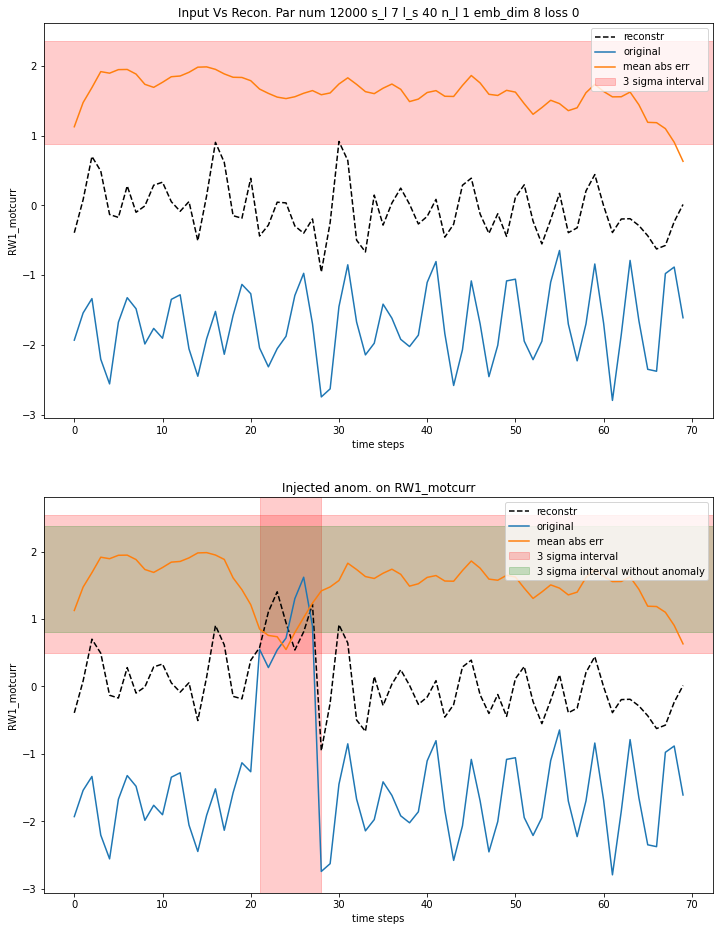

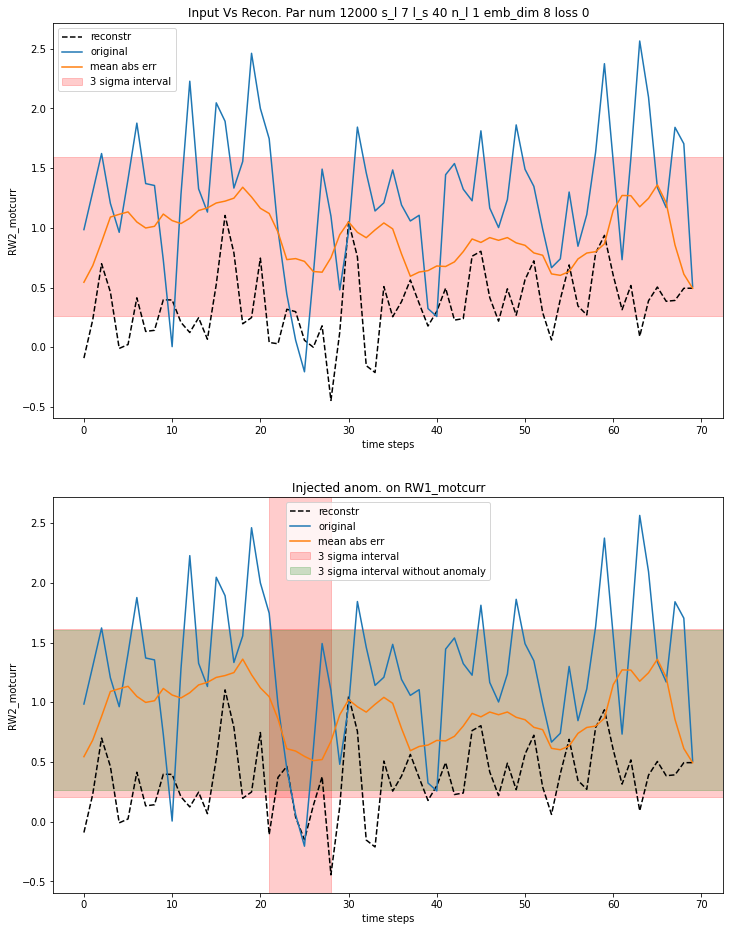

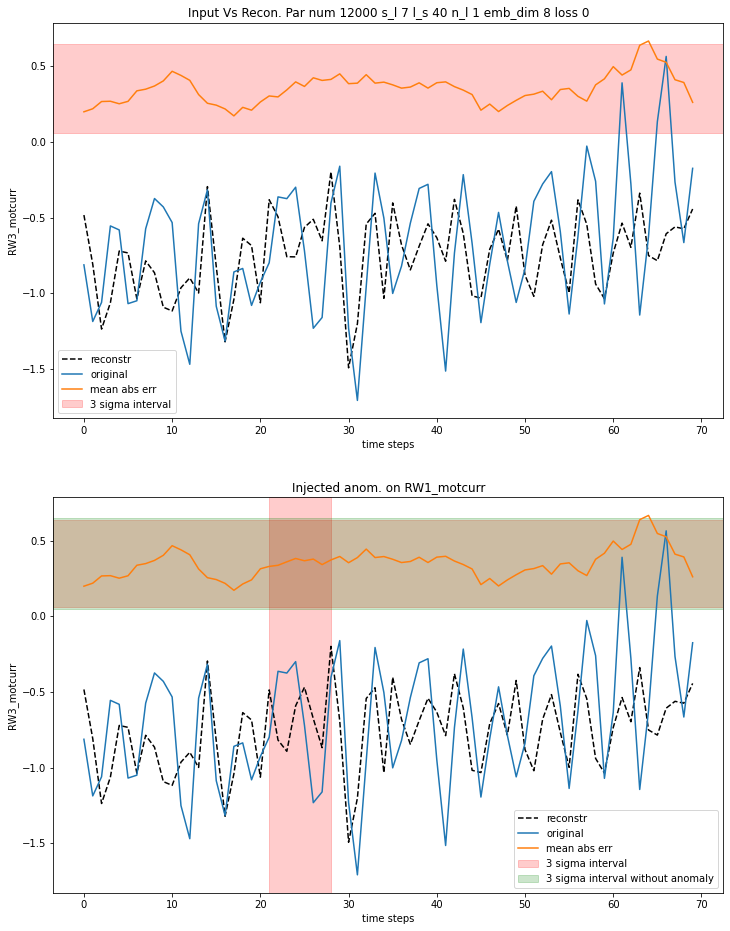

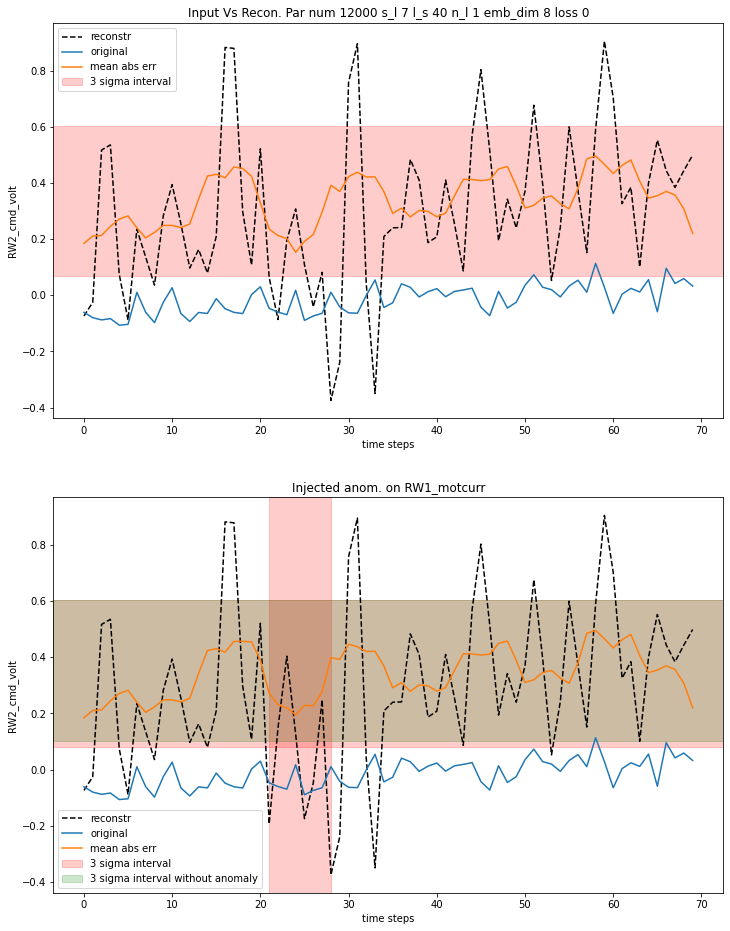

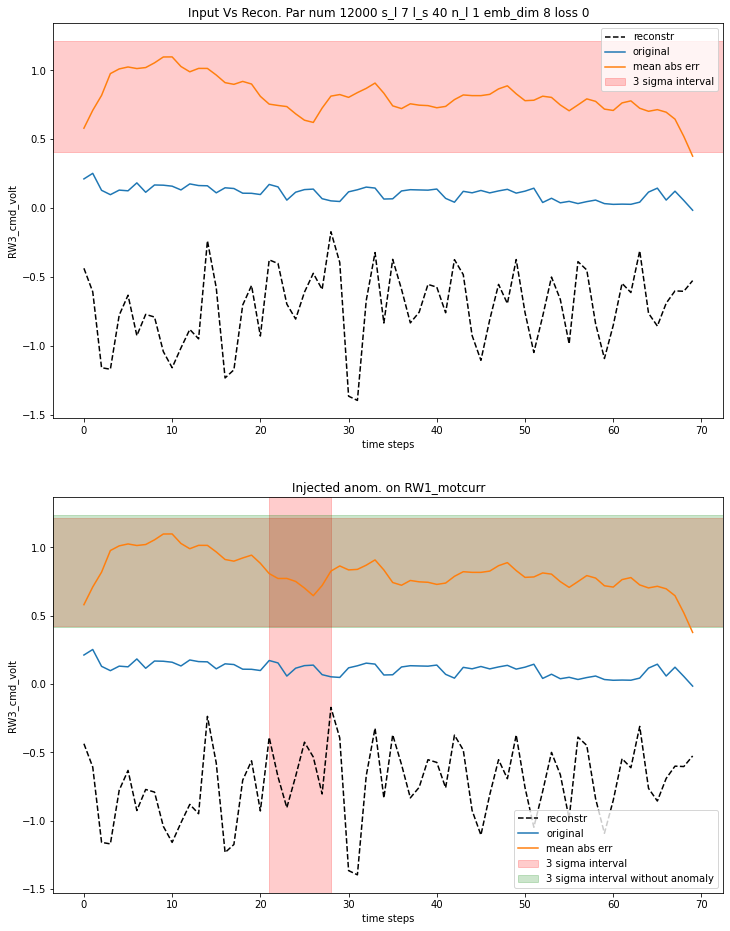

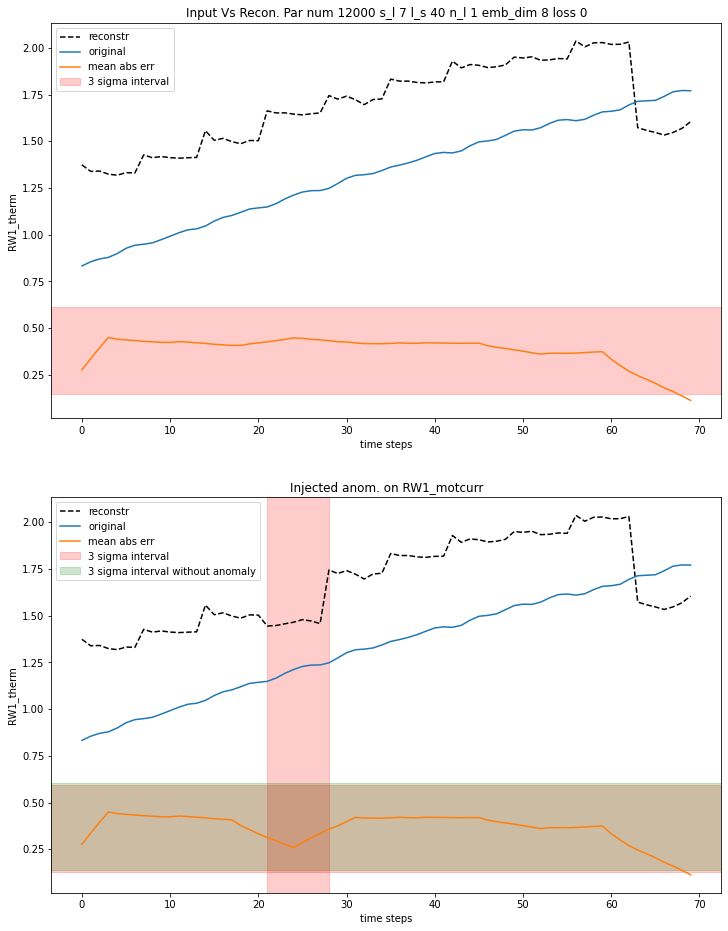

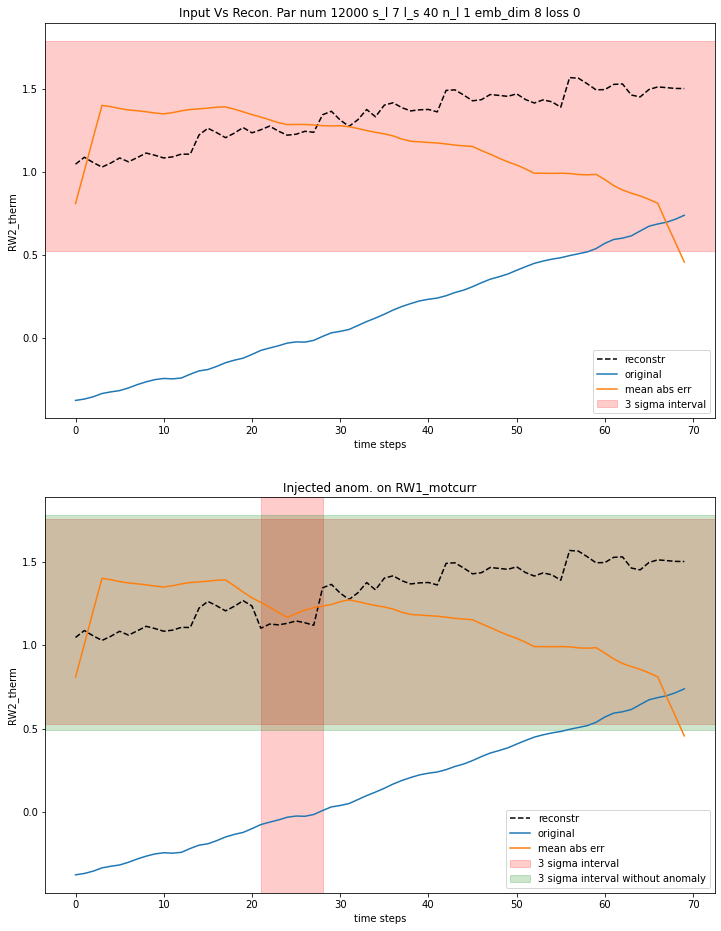

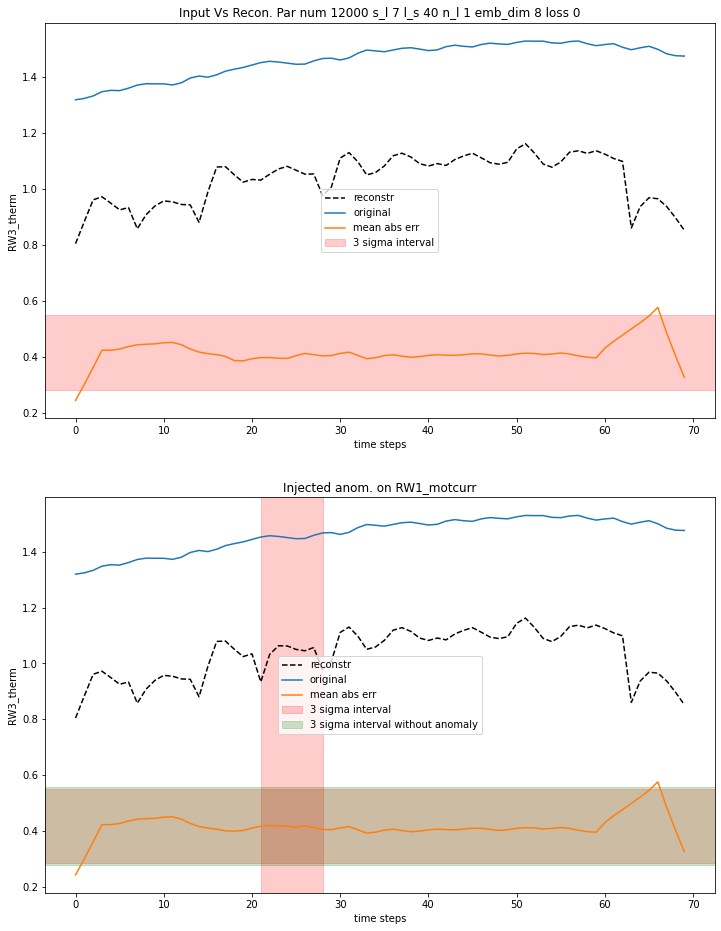

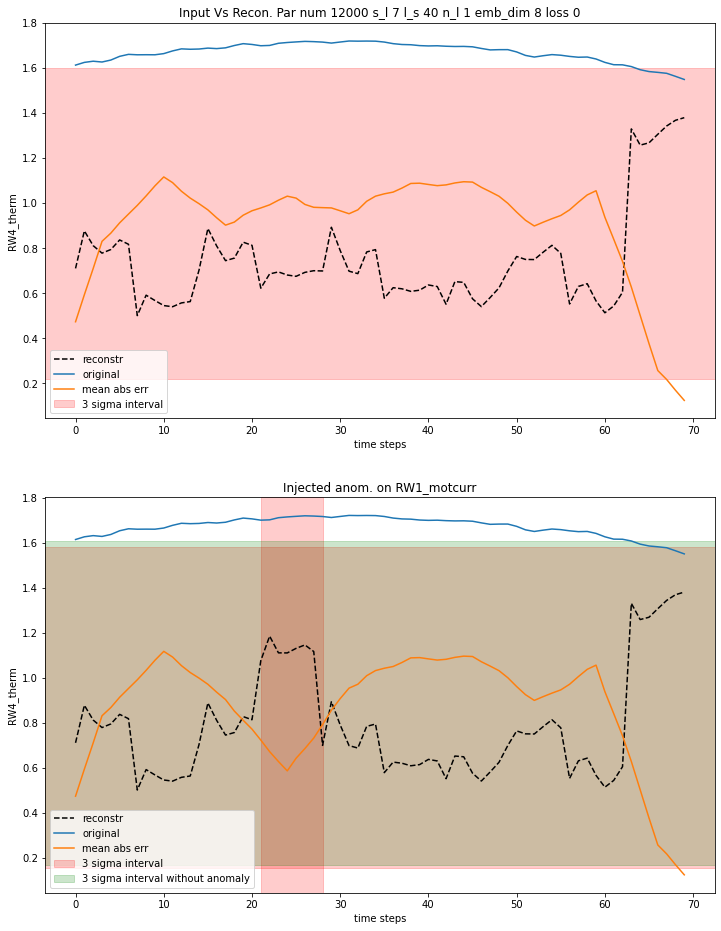

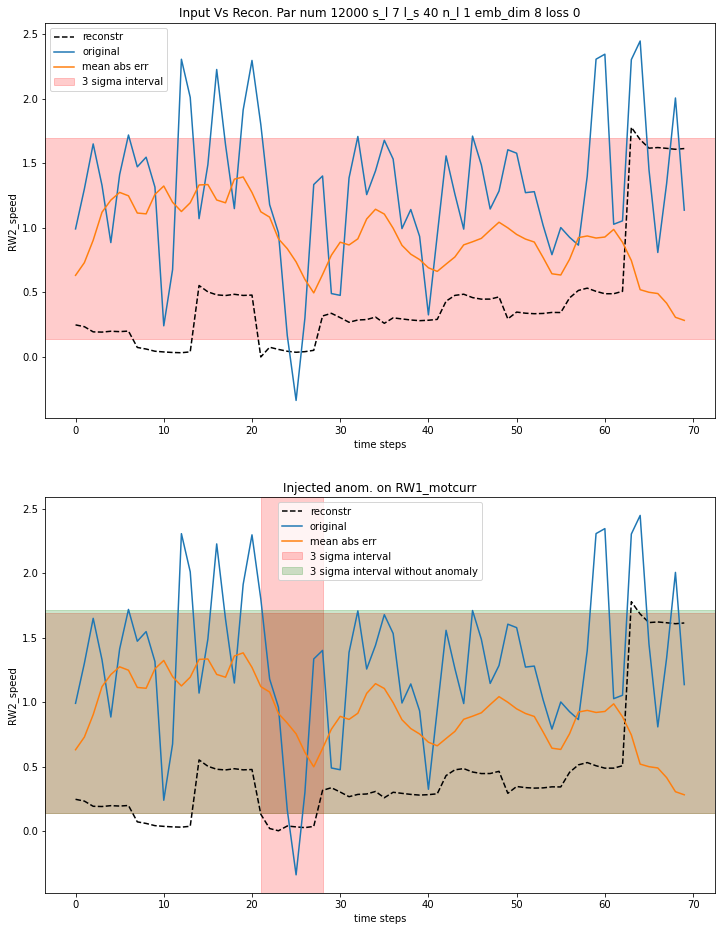

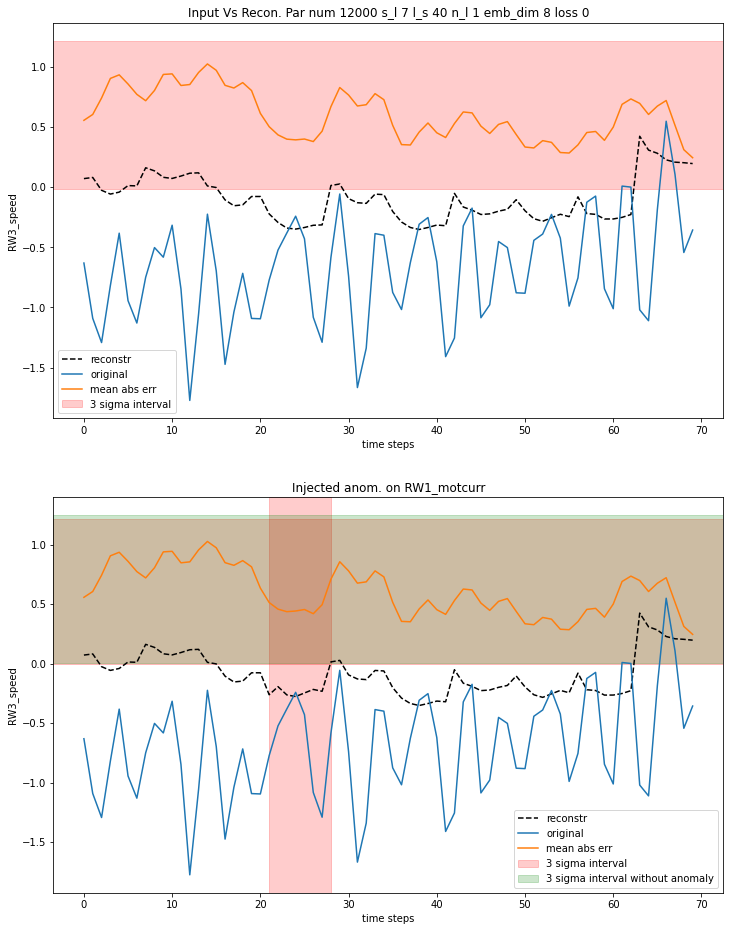

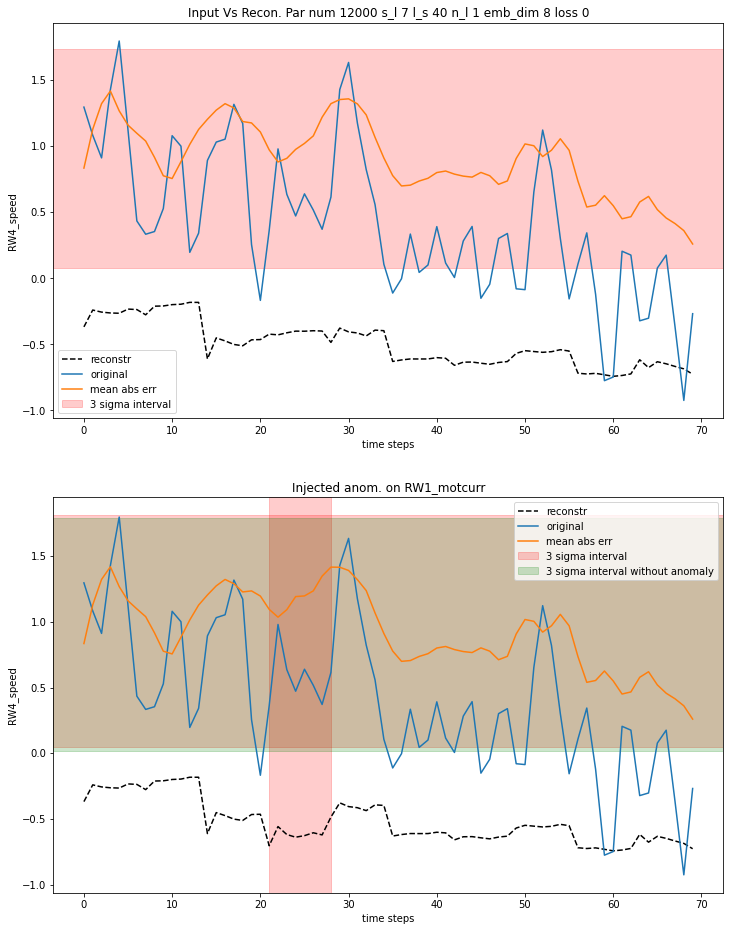

In [32]:
for i in range(x.shape[2]):
    fig, ax = plt.subplots(2,1, figsize=(12,16))

    ax[0].plot(yo.flatten(0,1)[:,i].to("cpu").detach().numpy(), 
               linestyle='--', label='reconstr', color='black')
    ax[0].plot(x.flatten(0,1)[:,i].to("cpu").detach().numpy(), label ='original')
    x_i = x.flatten(0,1)[:,i]
    y_o = yo.flatten(0,1)[:,i]

    loss_u = torch.nn.L1Loss(reduction='none')(y_o, x_i)
    loss_u = moving_average(loss_u.to("cpu").detach().numpy(), seq_len)

    ax[0].plot(loss_u, label ='mean abs err')
    ax[0].set_xlabel('time steps')
    ax[0].set_ylabel('{}'.format(cols[i]))
    ax[0].set_title('Input Vs Recon. Par num {} s_l {} l_s {} n_l {} emb_dim {} loss {}'\
                    .format(par_nums, seq_len, 
                            latent_dim, params_conf['n_layers'],
                            params_conf['embedding_dim'],
                            np.round(checkpoint['loss'],2)))
    #ax[0].hlines(np.mean(loss_u), 0, len(x_i), colors='green')
    ax[0].axhspan(np.mean(loss_u)-3*np.std(loss_u),
                  np.mean(loss_u)+3*np.std(loss_u)
                  , alpha=0.2, color='red', label='3 sigma interval')

    
    #ax[0].axhspan(np.mean(filtered)-3*np.std(loss_u),
    #              np.mean(loss_u)+3*np.std(loss_u)
    #              , alpha=0.2, color='green', label='3 sigma interval without anomaly')
    
    ax[0].legend()


    ax[1].plot(ya.flatten(0,1)[:,i].to("cpu").detach().numpy(), 
               linestyle='--', label='reconstr', color='black')
    ax[1].plot(xa.flatten(0,1)[:,i].to("cpu").detach().numpy(), label ='original')

    x_i = xa.flatten(0,1)[:,i]
    y_o = ya.flatten(0,1)[:,i]

    loss_u = torch.nn.L1Loss(reduction='none')(y_o, x_i)
    loss_u = moving_average(loss_u.to("cpu").detach().numpy(), seq_len)
    filtered = np.concatenate((loss_u[0:(batch[0])*seq_len], loss_u[(batch[0]+1)*seq_len:]))

    #y_test = x_i[(batch[0])*seq_len:(batch[0]+1)*seq_len].to("cpu").detach().numpy()
    #pred = y_o[(batch[0])*seq_len:(batch[0]+1)*seq_len].to("cpu").detach().numpy()
    #mape = np.mean(np.abs((y_test - pred) / y_test))

    ax[1].plot(loss_u, label ='mean abs err')
    ax[1].set_xlabel('time steps')
    ax[1].set_ylabel('{}'.format(cols[i]))
    ax[1].set_title('Injected anom. on {}'\
                    .format(cols[feats[0]]))
                           #,mape
                           #,loss))

    ax[1].axvspan((batch[0])*seq_len, (batch[0]+1)*seq_len, alpha=0.2, color='red')
    #ax[1].hlines(np.mean(loss_u), 0, len(x_i), colors='green', label = 'anom seq in {} with {} sigma deviation'\
    #             .format(feats[0], sigma))
    ax[1].axhspan(np.mean(loss_u)-3*np.std(loss_u),
                  np.mean(loss_u)+3*np.std(loss_u), alpha=0.2, color='red', label='3 sigma interval')
        
    ax[1].axhspan(np.mean(filtered)-3*np.std(filtered),
                  np.mean(filtered)+3*np.std(filtered)
                  , alpha=0.2, color='green', label='3 sigma interval without anomaly')
    ax[1].legend()

    if save:
        os.makedirs(path, exist_ok=True)
        plt.savefig(path + '{}_shift_{}_{}_sigma_{}_batch_{}.png'.format(cols[i],shift,sigma,i, num_batch))


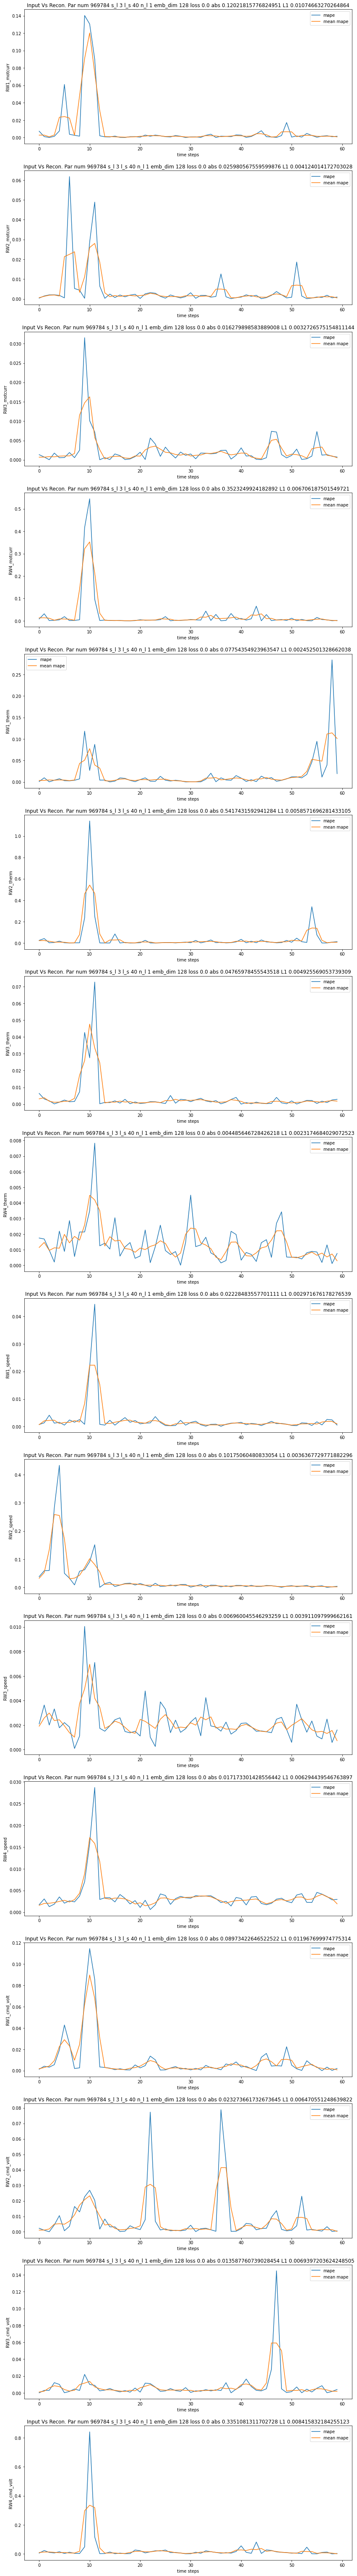

In [244]:
fig, ax = plt.subplots(16, figsize=(14,112))

for i in range(x.shape[2]):

    #ax[i].plot(yo.flatten(0,1)[:100,i].to("cpu").detach().numpy(), linestyle='--', label='reconstr')
    #ax[i].plot(x.flatten(0,1)[:100,i].to("cpu").detach().numpy(), label ='original')
    x_i = x.flatten(0,1)[:100,i]
    y_o = yo.flatten(0,1)[:100,i]

    loss = torch.nn.L1Loss()(y_o, x_i)
    loss_u = torch.nn.L1Loss(reduction='none')(y_o, x_i)
    loss_u = loss_u.to("cpu").detach().numpy() / np.abs(x_i.to("cpu").detach().numpy())
    
    mean = moving_average(loss_u, seq_len)

    
    y_test = x_i[(batch[0])*seq_len:(batch[0]+1)*seq_len].to("cpu").detach().numpy()
    pred = y_o[(batch[0])*seq_len:(batch[0]+1)*seq_len].to("cpu").detach().numpy()
    
    mape = np.mean(np.abs((y_test - pred) / y_test))

    #ax[i].plot(loss_mse_u_per.to("cpu").detach().numpy(), label ='mse')
    ax[i].plot(loss_u, label ='mape')
    ax[i].plot(mean, label ='mean mape')
    
    ax[i].set_xlabel('time steps')
    ax[i].set_ylabel('{}'.format(cols[i]))
    ax[i].set_title('Input Vs Recon. Par num {} s_l {} l_s {} n_l {} emb_dim {} loss {} abs {} L1 {}'\
                    .format(par_nums, seq_len, 
                            latent_dim, params_conf['n_layers'],
                            params_conf['embedding_dim'],
                            np.round(checkpoint['loss'],2)
                           ,mape
                           ,loss))
    
    ax[i].legend()
    #if i%4==0 and i != 0:
    #    j+=1
if save:
    os.makedirs(path, exist_ok=True)
    plt.savefig(path + 'reconstruction_results_shift_{}_{}_error_compare.png'.format(shift,sigma))

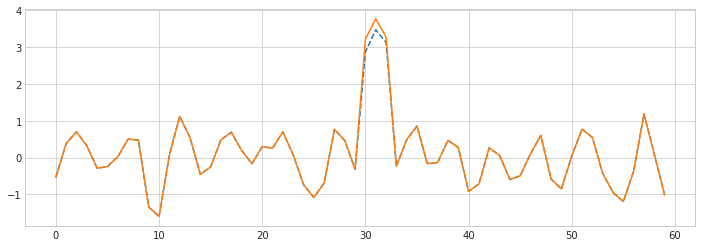

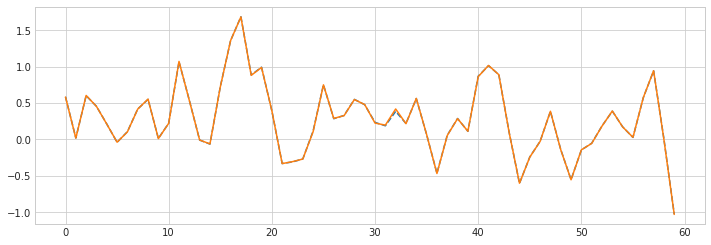

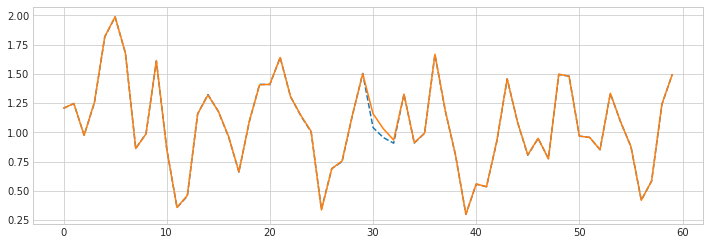

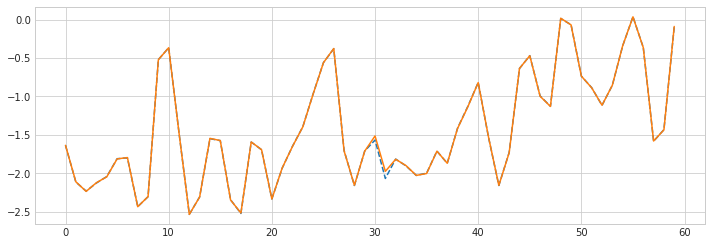

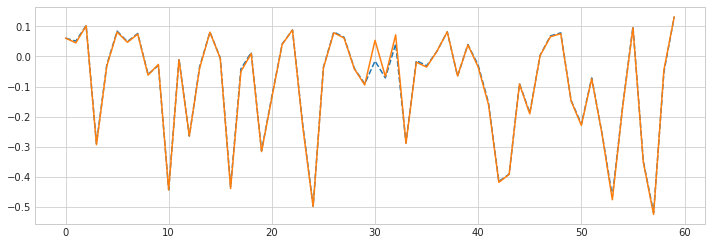

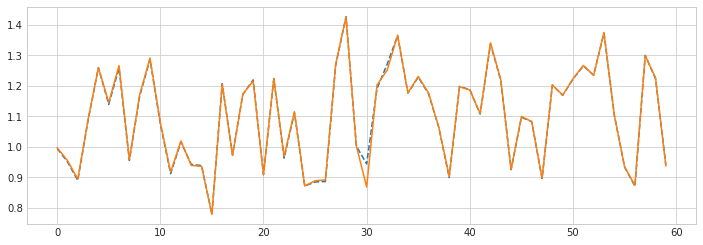

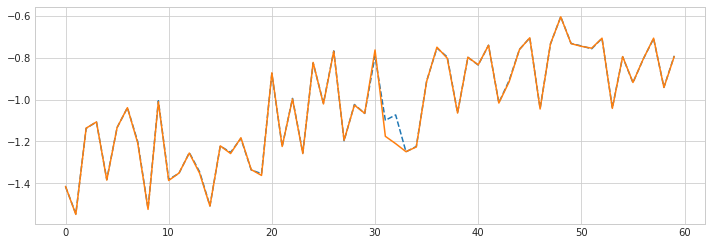

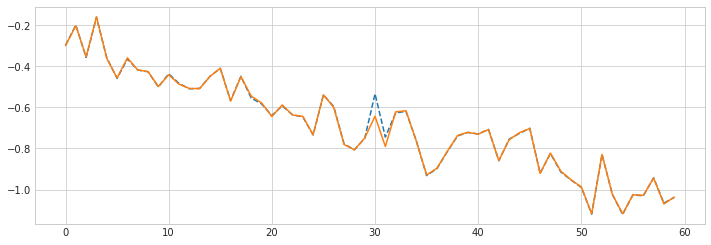

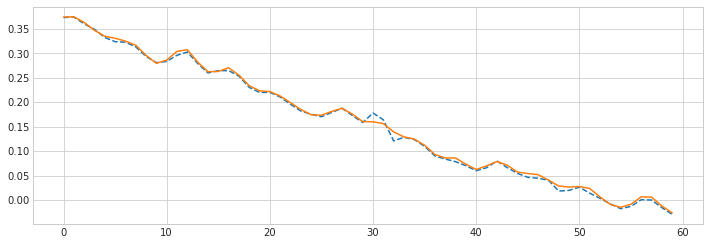

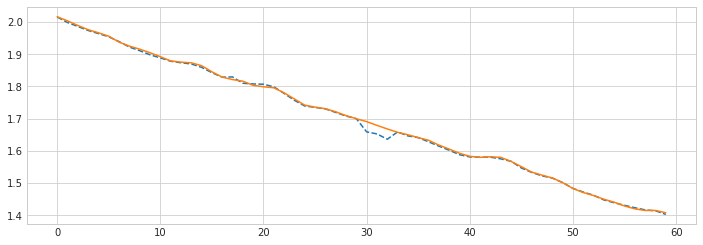

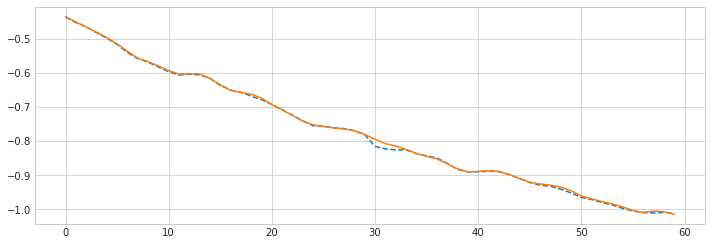

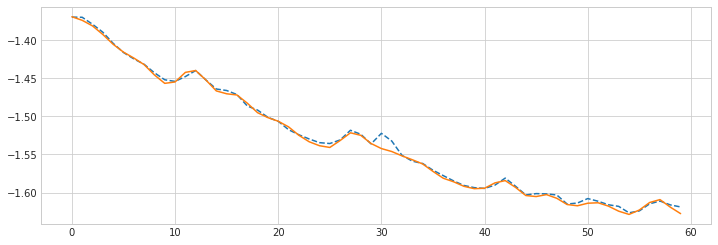

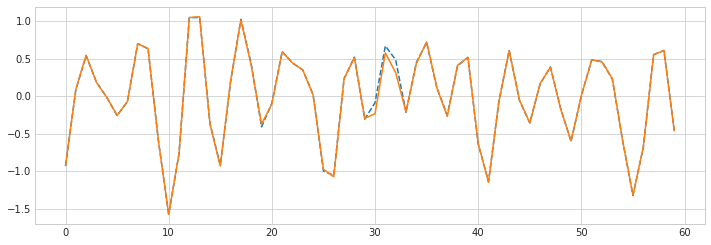

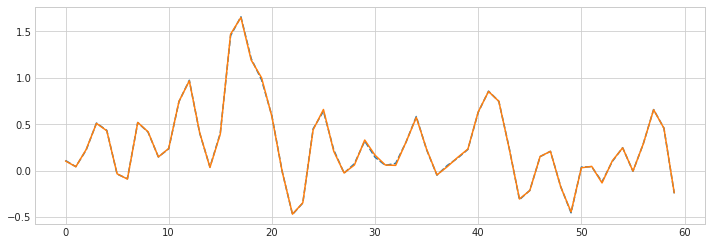

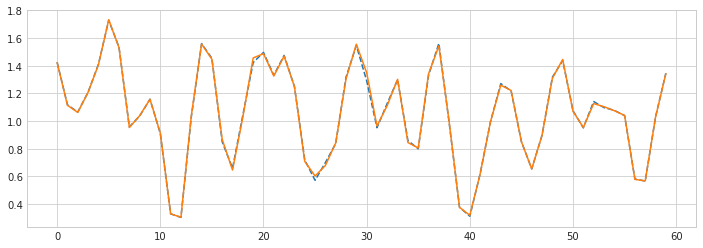

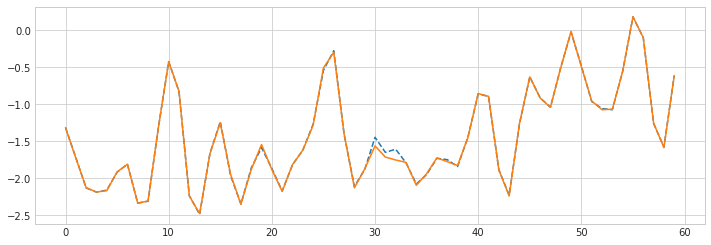

In [28]:
for i in range(x.shape[2]):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(12,4))
    #x = np.linspace(0, sequence_length)
    plt.plot(yo.flatten(0,1)[:,i].to("cpu").detach().numpy(), linestyle='--')

    plt.plot(x.flatten(0,1)[:,i].to("cpu").detach().numpy())

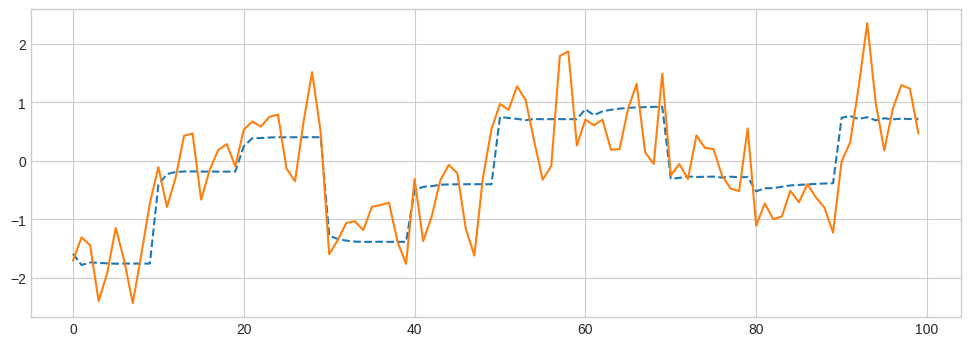

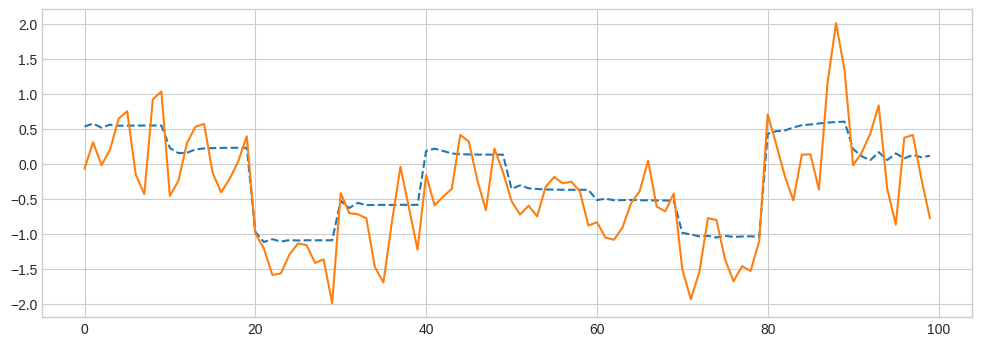

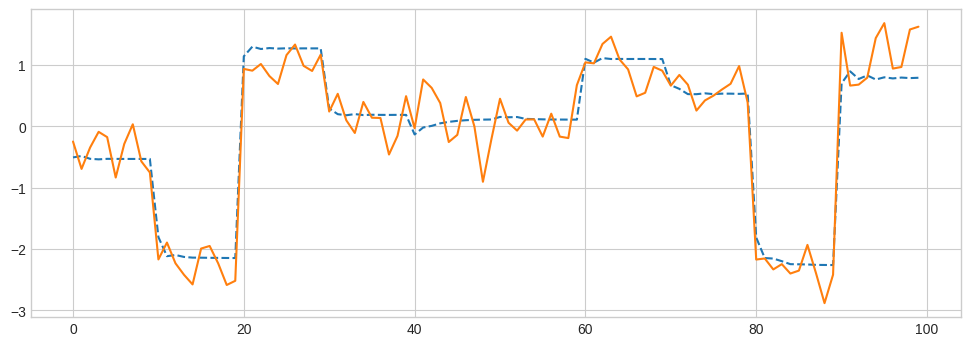

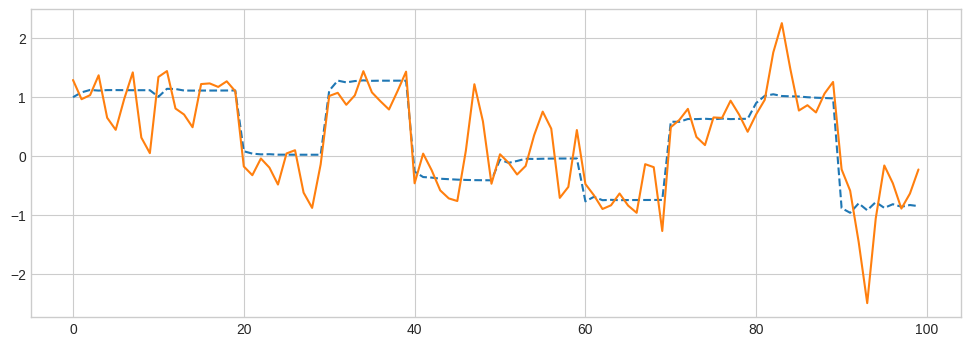

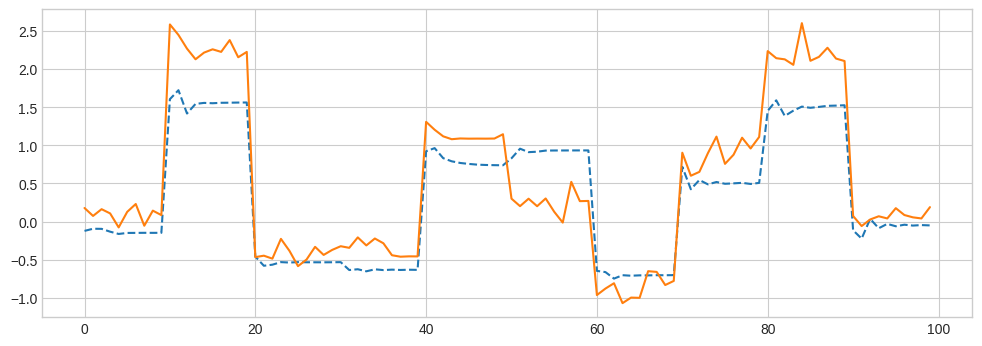

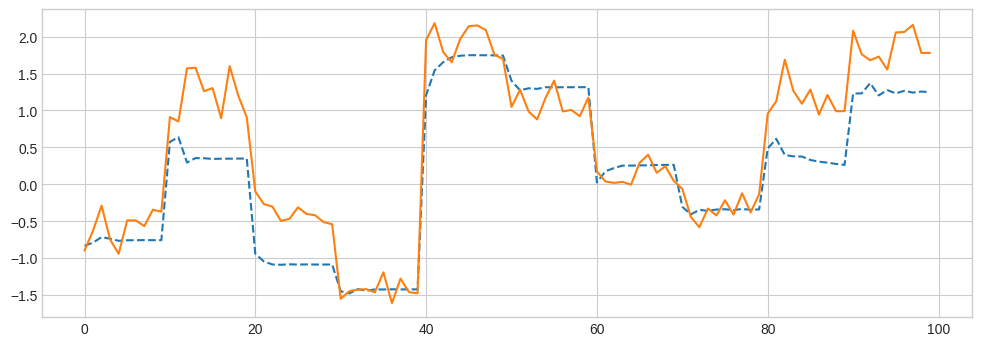

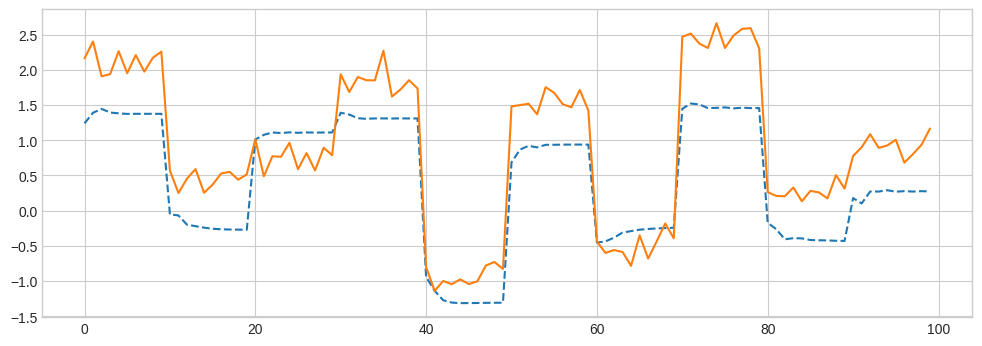

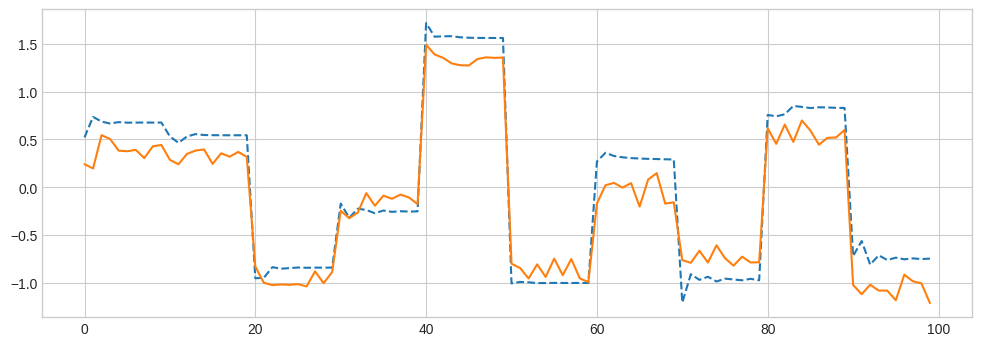

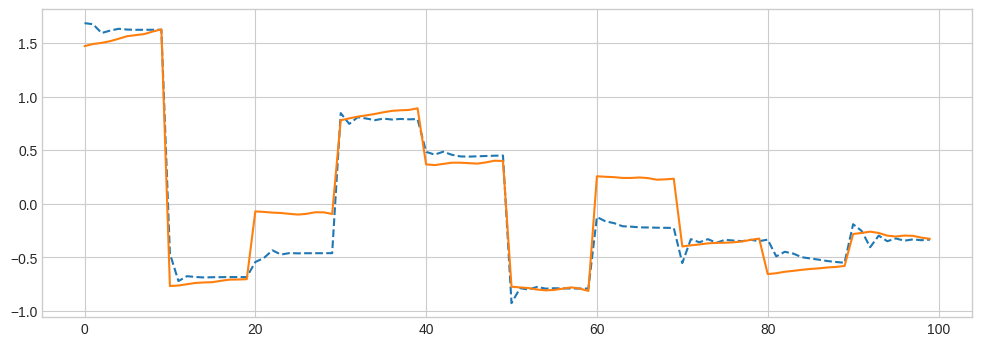

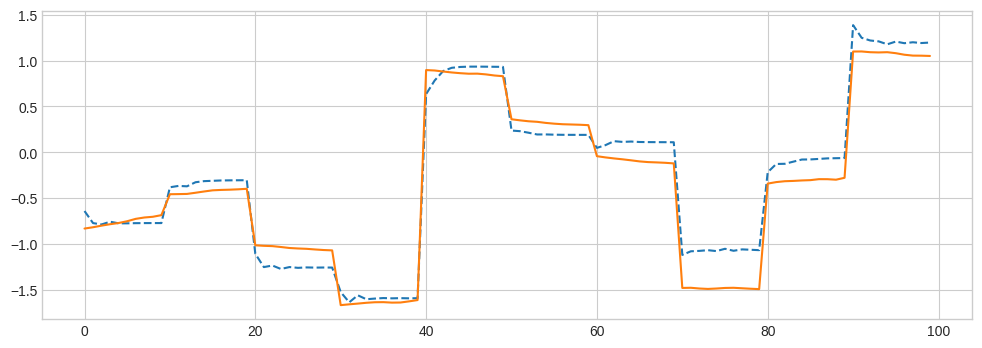

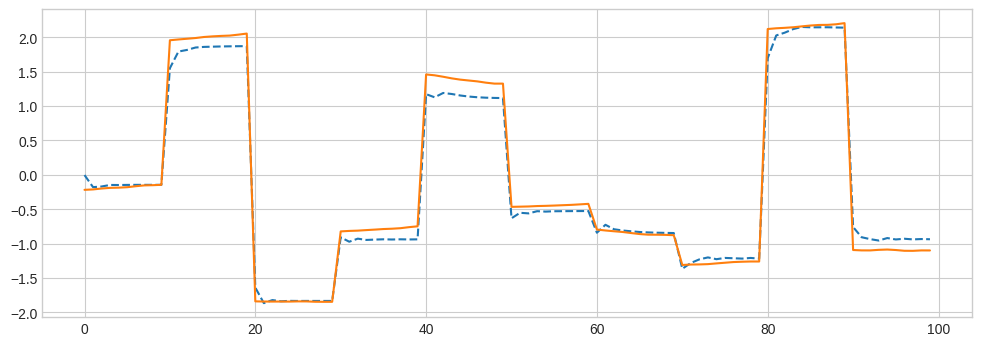

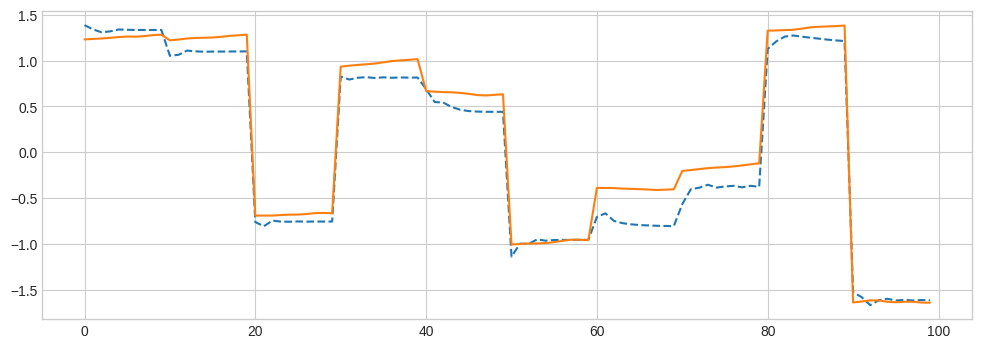

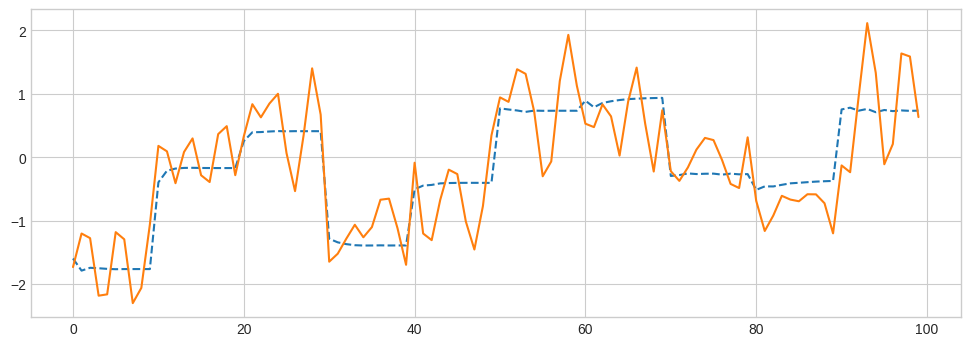

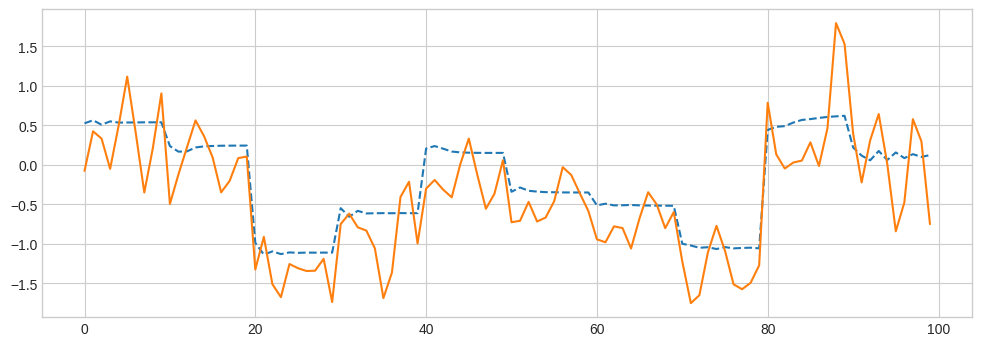

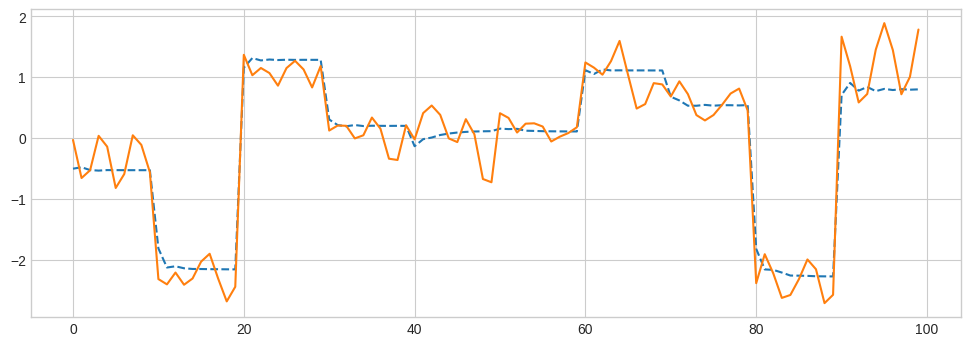

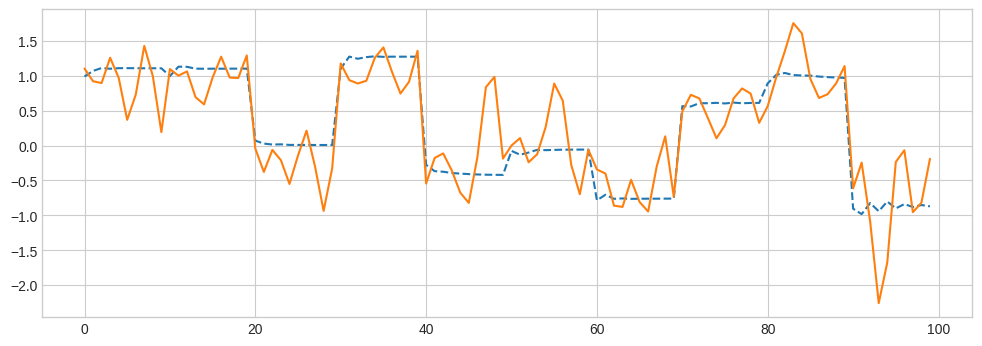

In [44]:
for i in range(x.shape[2]):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(12,4))
    #x = np.linspace(0, sequence_length)
    plt.plot(yo.flatten(0,1)[:,i].to("cpu").detach().numpy(), linestyle='--')

    plt.plot(x.flatten(0,1)[:,i].to("cpu").detach().numpy())

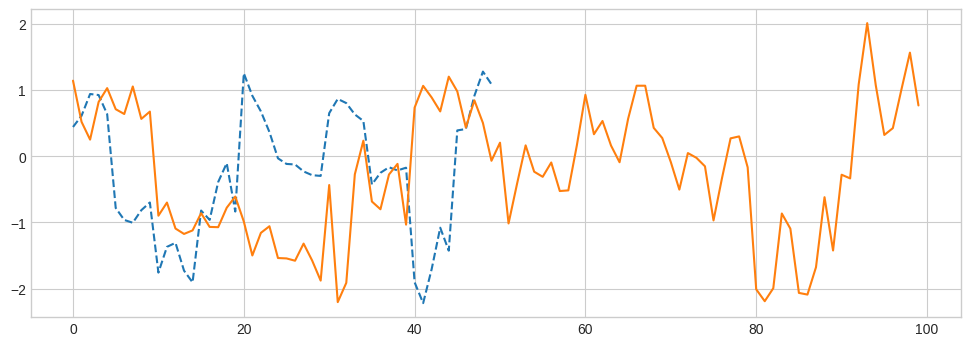

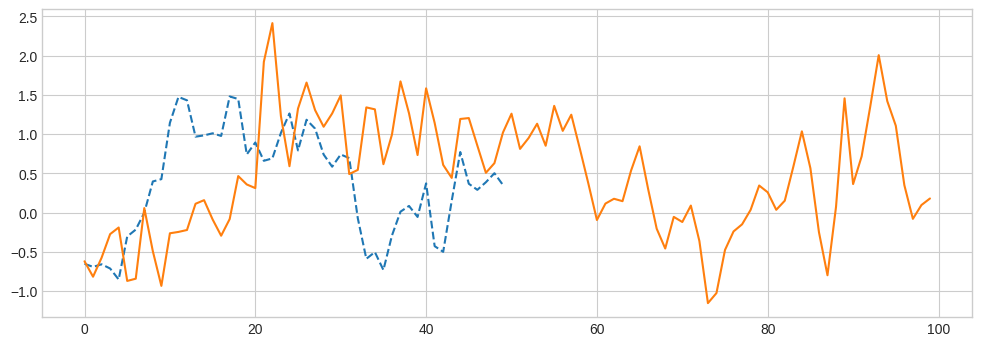

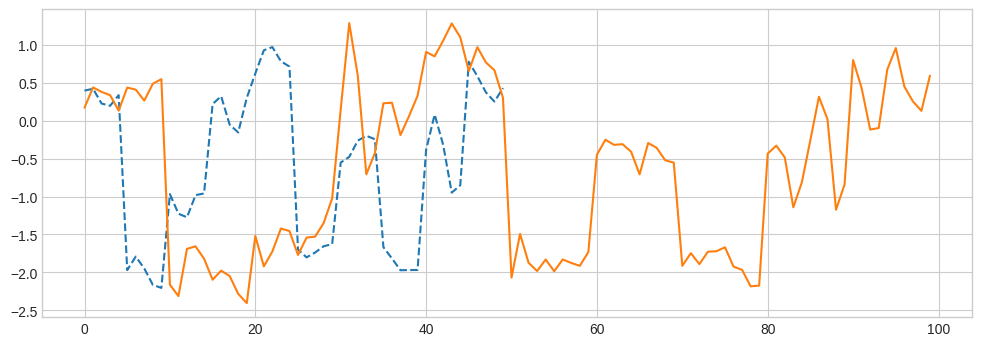

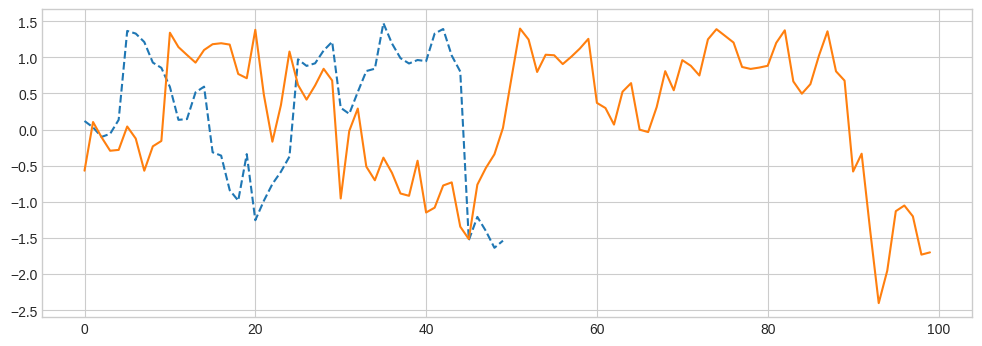

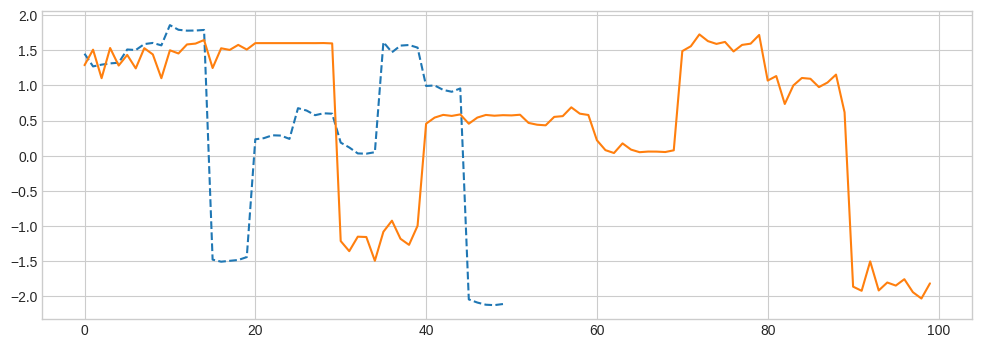

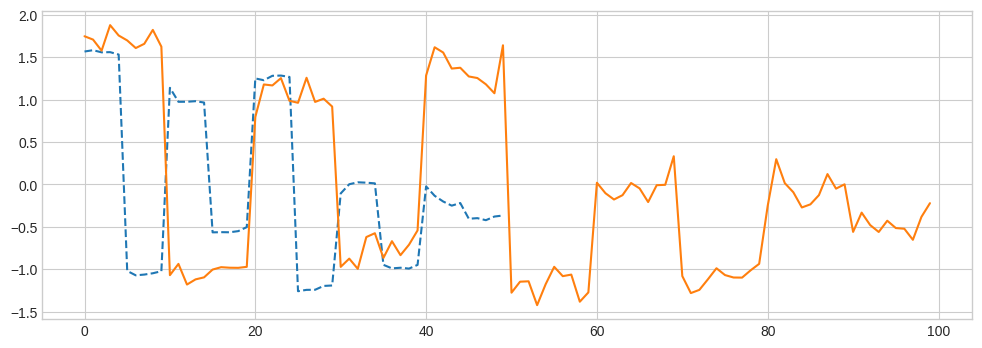

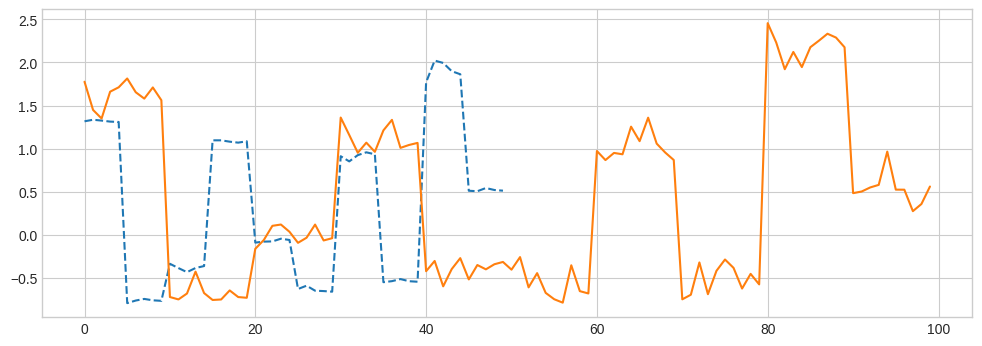

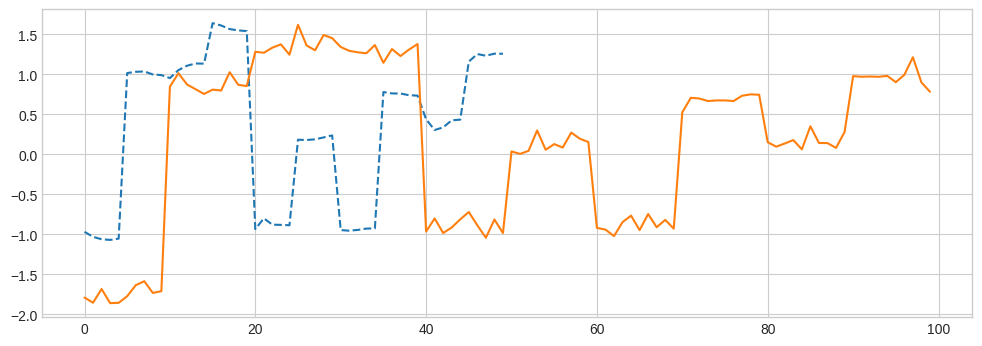

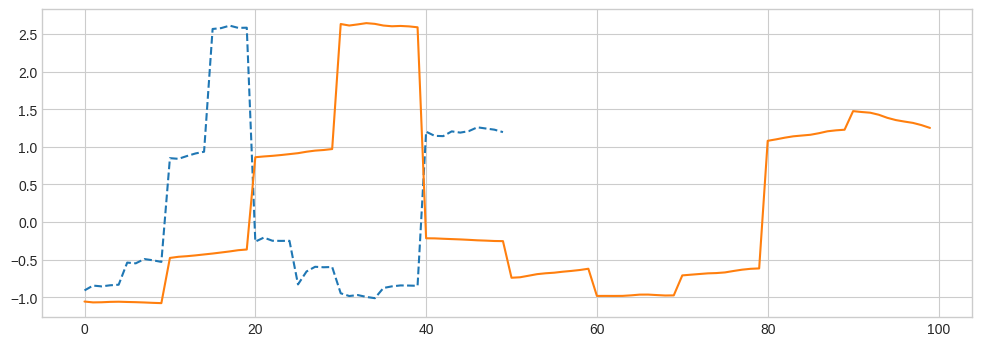

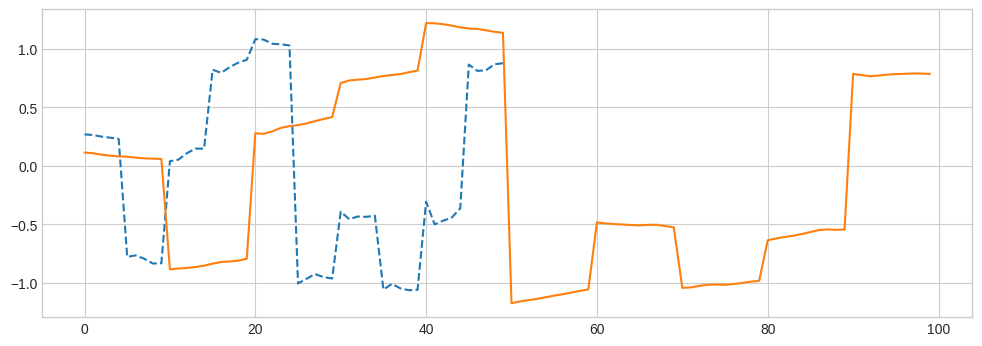

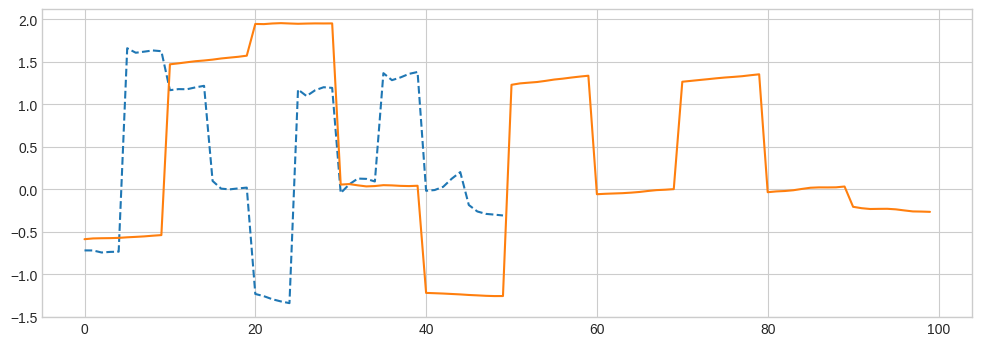

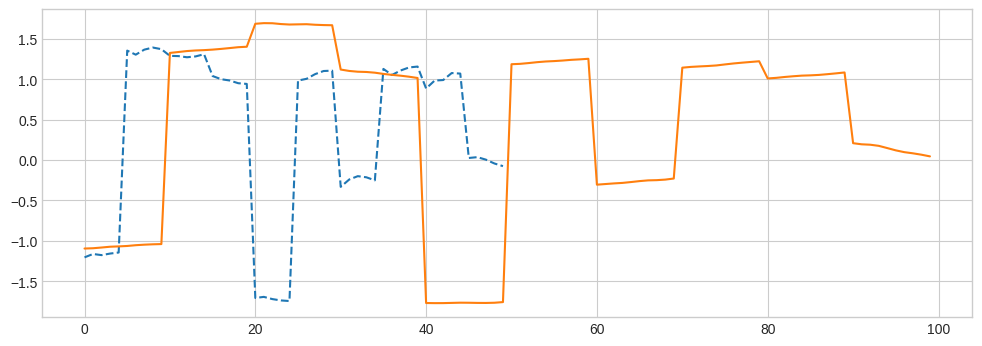

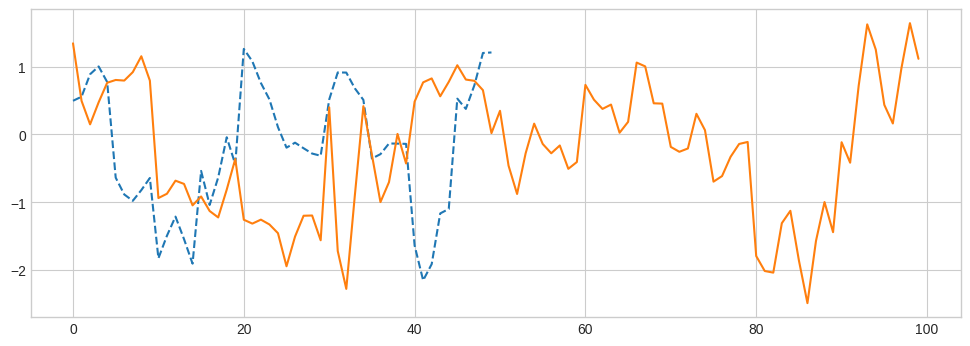

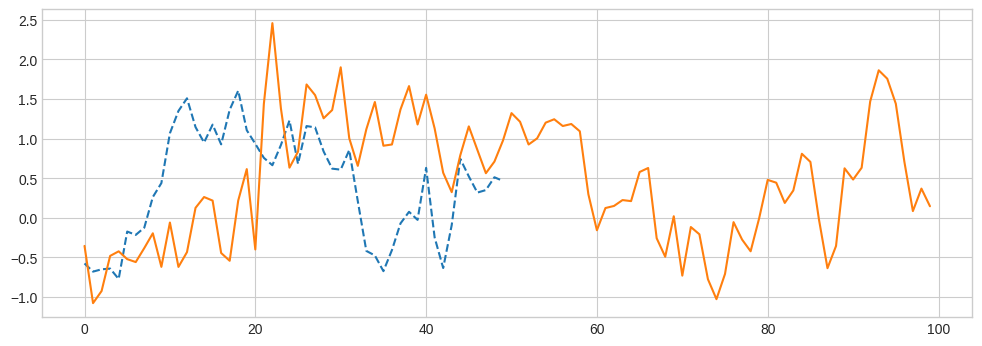

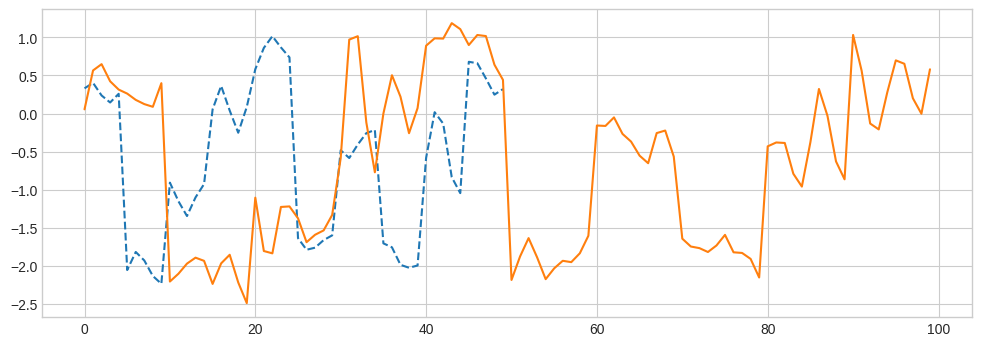

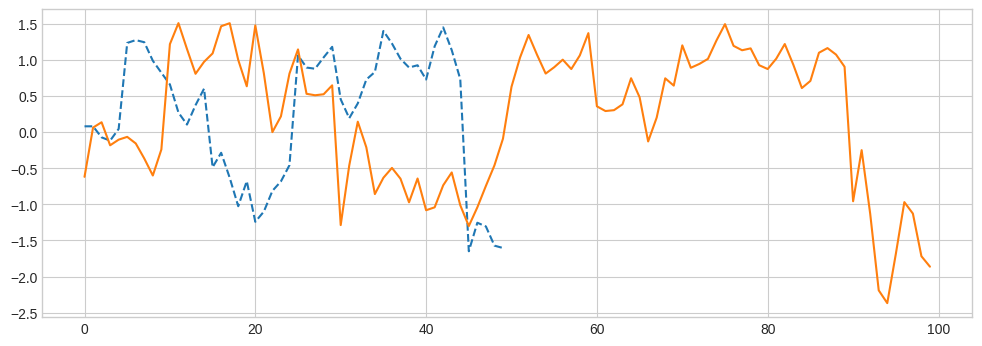

In [15]:
for i in range(x.shape[2]):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(12,4))
    #x = np.linspace(0, sequence_length)
    plt.plot(yo.flatten(0,1)[:,i].to("cpu").detach().numpy(), linestyle='--')

    plt.plot(x.flatten(0,1)[:,i].to("cpu").detach().numpy())

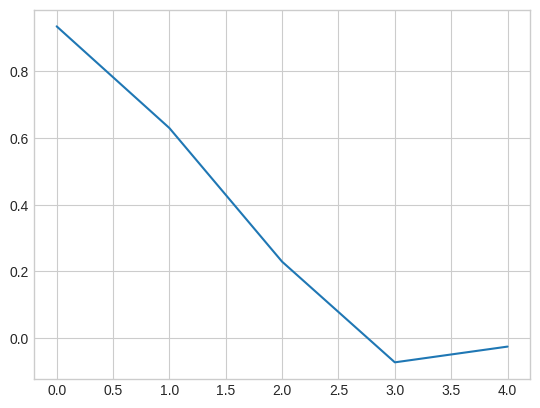

In [18]:
x, y = next(iter(test_iter))
x, enc, yo = model(x.to('cuda'))
feat = 0

if predict:
    plt.plot(y[0,:,feat].to("cpu").detach().numpy())
else:
    plt.plot(x[0,:,feat].to("cpu").detach().numpy())

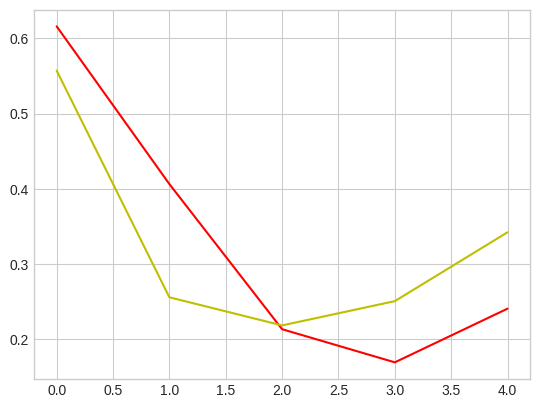

In [19]:
plt.plot(yo[1,:,feat].to("cpu").detach().numpy(), 'r')
plt.plot(y[1,:,feat].to("cpu").detach().numpy(), 'y')

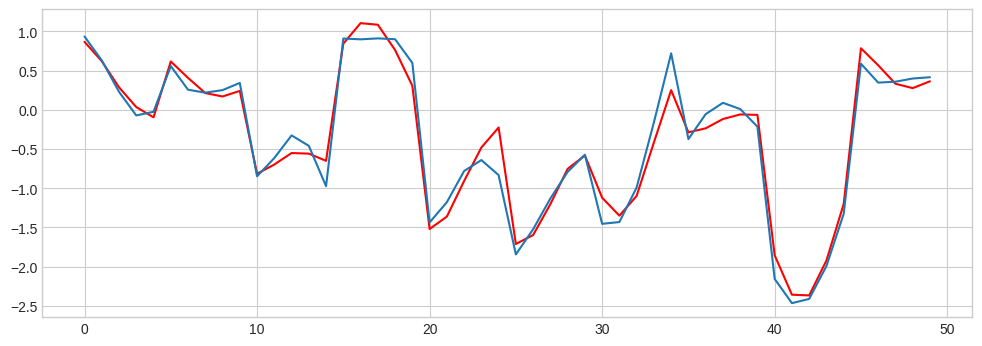

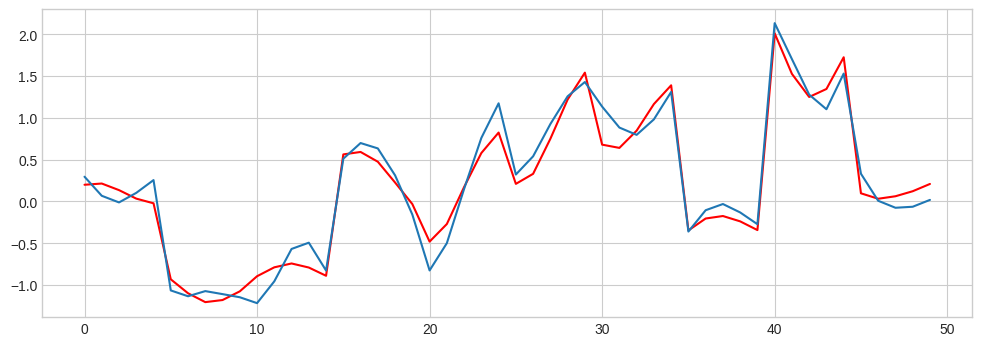

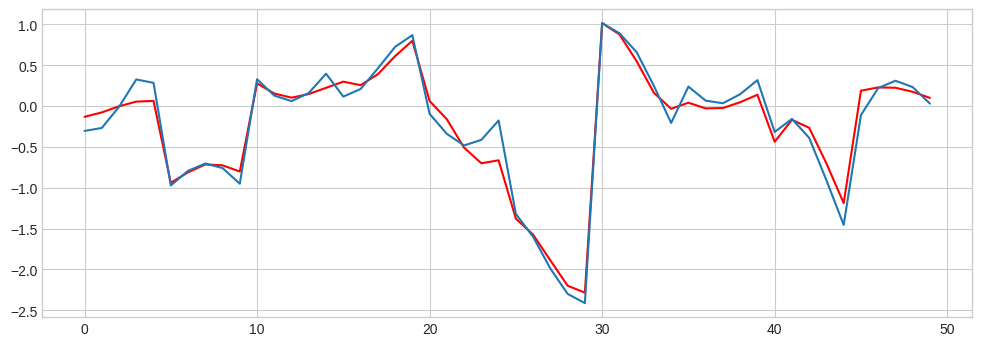

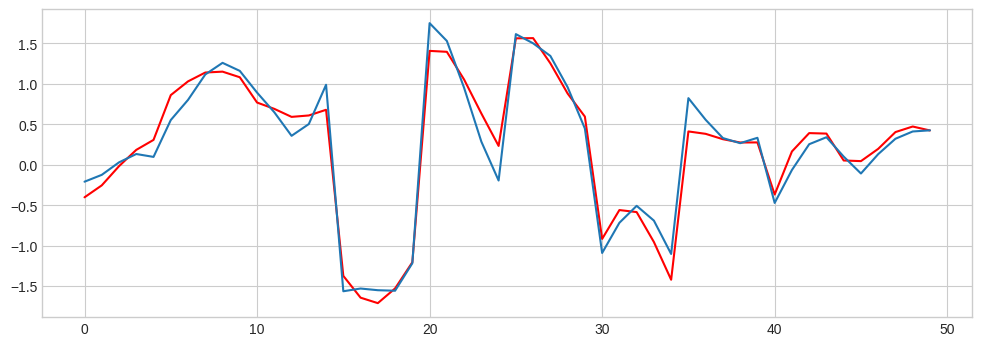

In [20]:
for i in range(x.shape[2]):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(12,4))
    #x = np.linspace(0, sequence_length)
    plt.plot(yo.flatten(0,1)[:100,i].to("cpu").detach().numpy(), 'r')
    plt.plot(x.flatten(0,1)[:100,i].to("cpu").detach().numpy())

#Inject anomaly

In [21]:
x, y = next(iter(test_iter))

In [25]:
n_std = 5

In [26]:
batch = 5
x_a = x.clone()
change_value = [0, 1,2]
injected = []
for i in range(x.shape[2]):
    print(i)
    if i in change_value:
        print('changing')
        inject = list(x_a[batch ,:, i].cpu().numpy())
        inject_anomaly = [t + n_std*np.std(inject)*random.uniform(0.8,1) for t in inject]
        #x_a[batch,:, i] =  torch.Tensor(fake)
        x_a[batch,:, i] = torch.Tensor(inject_anomaly)
        
        injected.append(i)
    
    if all(x_a[batch,:,i]==x[batch,:,i]):
        print('original tensor and anomalous are the same on features',i)

0
changing
1
changing
2
changing
3
original tensor and anomalous are the same on features 3


In [27]:
idx = batch*sequence_length
x_a, enc, yo_a = model(x_a.to('cuda'))
x, enc, yo = model(x.to('cuda'))
len(x_a.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy())

40

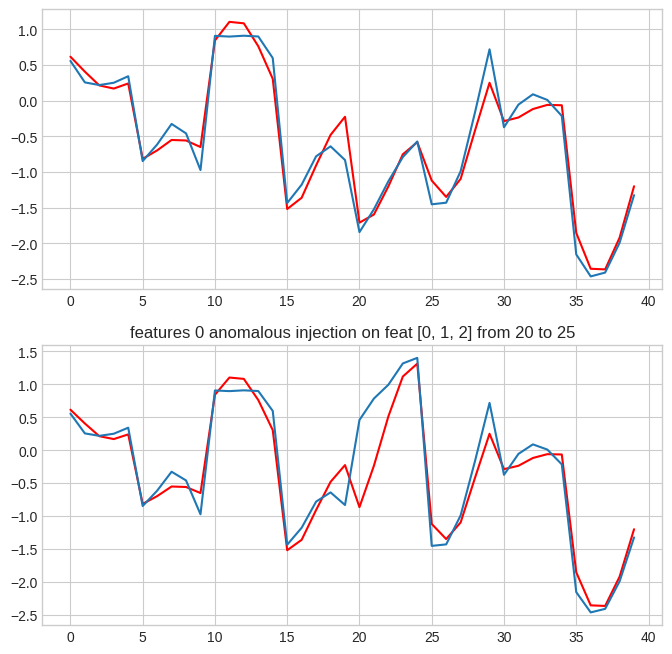

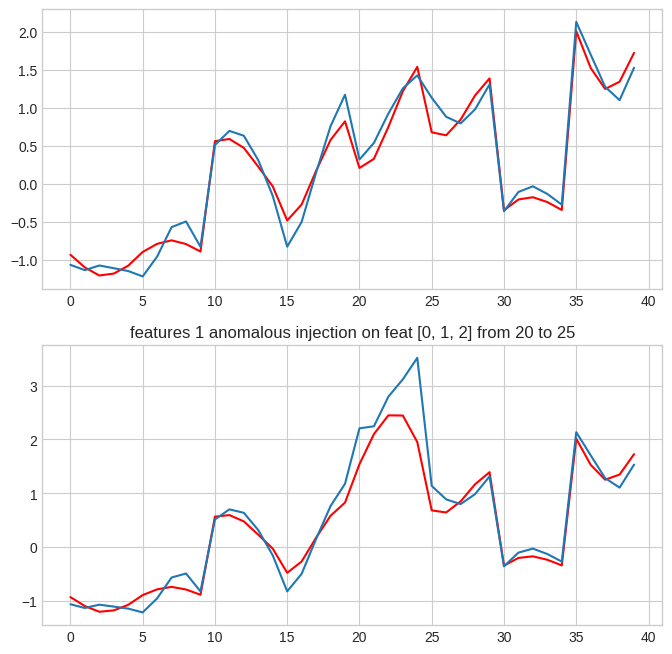

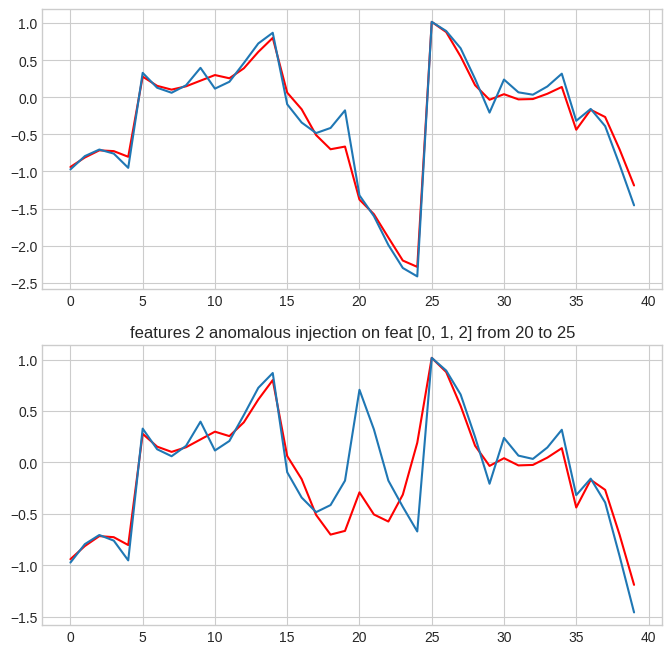

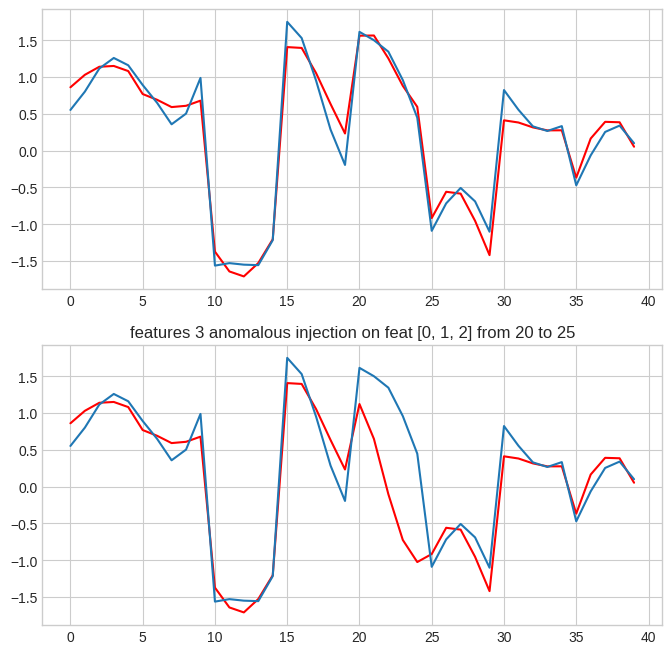

In [28]:
for i in range(x.shape[2]):
    plt.style.use('seaborn-whitegrid')
    fig, axs = plt.subplots(2, figsize=(8,8))
    #x = np.linspace(0, sequence_length)
    axs[0].plot(yo.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy(), 'r')
    axs[0].plot(x.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy())
    plt.title('no anomalies')
    axs[1].plot(yo_a.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy(), 'r')
    axs[1].plot(x_a.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy())

    an_idx = len(x_a.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy())//2

    plt.title('features {} anomalous injection on feat {} from {} to {}'\
              .format(i ,injected, int(an_idx), int(an_idx)+ batch))